# Lesson1 データ分析と機械学習の入り口
前回までは、比較的綺麗なデータを用いて、データ分析をするためのデータ読み込みやデータ加工、抽出、整形を行いました。これによって、ビジネス現場ではどのようなデータ分析を行うかのおおよそなイメージができたかと思います。今回は、データ分析にもっと踏み込んで『結果を出す』ための技術を学びます。

## 目次
* Section1 顧客の全体像を把握する
  * 1.1 データを読み込んで把握する
  * 1.2 顧客データを整形する
  * 1.3 顧客データの基礎集計する
  * 1.4 最新顧客データの基礎集計する
  * 1.5 利用履歴データを集計する
  * 1.6 利用履歴データから定期利用フラグを作成する
  * 1.7 顧客データと利用履歴データを結合する
  * 1.8 会員期間を計算する
  * 1.9 顧客行動の各統計量を把握する
  * 1.10 退会ユーザーと継続ユーザーの違いを把握する 

* Section2 顧客の行動を予測する
  * 2.1 データを読み込む
  * 2.2 クラスタリング結果で顧客をグループ化する
  * 2.3 クラスタリング結果を分析する
  * 2.4 クラスタリング結果を可視化する
  * 2.5 クラスタリング結果をもとに退会ユーザーの傾向を把握する
  * 2.6 翌月の利用回数予測を行うためのデータを準備する
  * 2.7 特徴となる変数を付与する
  * 2.8 来月の利用回数予測モデルを作成する
  * 2.9 モデルに寄与している変数を確認する
  * 2.10 来月の利用回数を予測する

* Section3 顧客の退会を予測する
  * 3.1 データを読み込み利用データを整形する
  * 3.2 退会前月の退会顧客データを整形する
  * 3.3 継続顧客のデータを作成する
  * 3.4 予測する月の在籍期間を作成する
  * 3.5 欠損値を除去する
  * 3.6 文字列型の変数を処理できるように整形する
  * 3.7 決定木を用いて退会予測モデルを作成する
  * 3.8 予測モデルの評価を行い、モデルのチューニングを行う
  * 3.9 モデルに寄与している変数を確認する
  * 3.10 顧客の退会を予測する

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


※MyDrive直下に機械学習プログラムフォルダ全体を格納しておくこと

In [ ]:
%cd drive/MyDrive/DSS_Public_learning_ds-main/vol2/

In [ ]:
!ls

DATA  lesson1_exercise.ipynb


## Section1
データ分析は一つの手段であって、その先のゴールは『何を達成するか』です。  
例えば、現在のデータから未来の予測をしたい、などです。未来を予測する(時系列予測など)ための方法は多くありますが、実際はデータを適切に加工してデータを可視化するだけでも、多くの情報を得ることが可能です。

今回は、架空のジムの顧客データを用いて、データ分析を行なっていきます。  
ゴールは、退会ユーザーと継続ユーザーの違いを見つけることです。



### 1.1：データを読み込んで把握する

In [ ]:
# まずはデータを読み込んで、先頭行からどのようなデータなのかをざっくり把握する
import pandas as pd
uselog = pd.read_csv('DATA/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


"use_log"は、どうやらユーザーの利用履歴っぽい

In [ ]:
customer = pd.read_csv('DATA/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


"customer_master"は、顧客マスタDBから取得してきたようなデータ

In [ ]:
class_master = pd.read_csv('DATA/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


"class_master"は、入会にあたっての契約種類のマスタデータ

In [ ]:
campaign_master = pd.read_csv('DATA/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


"campaign_master"は、入会の際のキャンペーン区分のデータ

### 1.2：顧客データを整形する

In [ ]:
# ここで顧客データの整形を行います
# データ列も異なるため、mergeを利用します
customer_join = pd.merge(customer, class_master, on="class", how="left") #キーカラムを、classに
customer_join = pd.merge(customer_join, campaign_master, on="campaign_id", how="left") #キーカラムを、campaign_idに
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [ ]:
print(len(customer))
print(len(customer_join))

4192
4192


In [ ]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

"end_date"には、2842レコードにNA(欠損)があるよう

### 1.3：顧客データの基礎集計する
データの整形が終わった(1つのデータテーブルにまとめた)ので、この顧客データを集計して全体像を把握していきます。集計する項目は、どの項目かを考える必要があります。この場合、いつ入会があるのか、いつ退会するのか、どの会員区分が多いのか、どのキャンペーンもしくは通常で入会したのか、などがあるかと思います。

In [ ]:
customer_join.groupby("class_name").count()["customer_id"] # "class_name"でGROUPBYして、"customer_id"(ユニークなID)をカウントする

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [ ]:
customer_join.groupby("campaign_name").count()["customer_id"] # "campaign_name"でGROUPBYして、"customer_id"(ユニークなID)をカウントする

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [ ]:
customer_join.groupby("gender").count()["customer_id"] # "gender"でGROUPBYして、"customer_id"(ユニークなID)をカウントする

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [ ]:
customer_join.groupby("is_deleted").count()["customer_id"] # "is_deleted"でGROUPBYして、"customer_id"(ユニークなID)をカウントする

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [ ]:
# "start_date"を、pandasのdatetime型に変換する
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"]>pd.to_datetime("20180401")] # locを用いて、条件に一致するレコードを抽出する
print(len(customer_start))

1361


入会人数は、"start_date"が20180401~20190331までのユーザーとなります

1350人に対して、11人多いのは気になるところでが、一旦分析を進めていきます

### 1.4：最新顧客データの基礎集計する

In [ ]:
# 20190331に退会したユーザーもしくは在籍しているユーザーで、最新月のユーザーを絞り込む
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"]) # end_dateをdatetime型に
customer_newer = customer_join.loc[(customer_join["end_date"]>=pd.to_datetime("20190331"))|(customer_join["end_date"].isna())] #NAであれば、現在でも在籍しているユーザー
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
customer_newer.groupby("class_name").count()["customer_id"]

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [ ]:
customer_newer.groupby("campaign_name").count()["customer_id"]

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [ ]:
customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

### 1.5：利用履歴データを集計する
月の利用回数の平均、中央値、最大値、最小値、また定期的に利用しているユーザーのフラグを作成して、顧客データに追加して、集計を行なっていきましょう

In [ ]:
# 顧客ごと、月ごと利用回数を集計する
uselog["usedate"] = pd.to_datetime(uselog["usedate"]) # usedateを、datetime型に変換する
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m") # datetime型になったレコードから、年月日 -> 年月に置き換える
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count() # "年月","customer_id" でGROUPBYし、その月の同一顧客のカウントを行う
uselog_months.rename(columns={"log_id":"count"}, inplace=True) # "log_id"を"count"に置き換える
del uselog_months["usedate"] # "usedate"列を削除する（後で顧客データに追加するときに、列が重複するため）
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [ ]:
uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min" ])["count"]
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


### 1.6：利用履歴データから定期利用フラグを作成する
習慣化が、ジム利用の継続の重要な１つの要因と仮定します。

従って、定期的にジムを利用しているユーザーを特定する必要があります。(フラグを作成する) 『定期的』をどのように定義するかは別議論として、一旦、『毎週同じ曜日に来ている』を定期的と定義しましょう。月ごとにばらつきがあると考えられるため、顧客ごと月ごと曜日別に集計を行なって、最大値が４以上の曜日が1月でもあればフラグを１とします。

In [ ]:
uselog["weekday"] = uselog["usedate"].dt.weekday # 日付から曜日や年月日を取得するため、dt.weekdayを利用します
uselog_weekday = uselog.groupby(["customer_id","年月","weekday"], as_index=False).count()[["customer_id","年月", "weekday","log_id"]]
uselog_weekday.rename(columns={"log_id":"count"}, inplace=True)
uselog_weekday.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


dt.weekday　から、下記の整数値とそれに対応する曜日が定義されています
>>
0       Monday
1      Tuesday
2    Wednesday
3     Thursday
4       Friday
5     Saturday
6       Sunday

In [ ]:
# ここから4以上のカウントに対して、フラグを１、4未満のカウントに対して、フラグを0とします
uselog_weekday = uselog_weekday.groupby("customer_id",as_index=False).max()[["customer_id", "count"]]
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"]<4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


### 1.7：顧客データと利用履歴データを結合する

In [ ]:
customer_join = pd.merge(customer_join, uselog_customer, on="customer_id", how="left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on="customer_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1


In [ ]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

### 1.8：会員期間を計算する
会員である期間は、"start_date"と"end_date"との差で計算することが可能です。一方、現在(20190331以降)も会員である場合は、"end_date"は欠損値となっているため計算することができないため、一旦、20190430と置き換えて計算します。(必ず、こうしてくださいというわけではなく、今回は上記対応をしているだけ)
20190331で算出しようとすると、例えば、20190331時点で退会する人と見分けがつかなくなるため、1ヶ月未来の日付で置き換えています。

In [ ]:
from dateutil.relativedelta import relativedelta # 日付比較のためのPython標準ライブラリ
customer_join["calc_date"] = customer_join["end_date"] # 計算するための列を作成
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430")) # NAを20190430に置き換え
customer_join["membership_period"] = 0
for index_num in range(len(customer_join)): # customer_joinのレコード分、繰り返し処理をする
    delta = relativedelta(customer_join["calc_date"].iloc[index_num], customer_join["start_date"].iloc[index_num]) # 日付の差を計算する
    customer_join["membership_period"].iloc[index_num] = delta.years*12 + delta.months # 会員期間(日付の差)を、月数に置き換える
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


### 1.9：顧客行動の各種統計量を把握する

In [ ]:
customer_join[["mean", "median", "max", "min"]].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [ ]:
customer_join.groupby("routine_flg").count()["customer_id"]

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

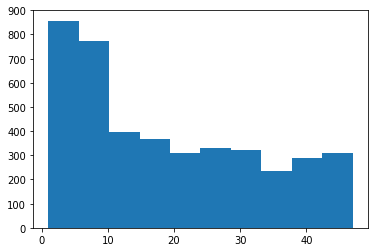

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

10ヶ月未満が最も多く、10ヶ月以上は、横ばい。短期でユーザーが離脱してしまう業界のようです。

### 1.10：退会ユーザーと継続ユーザーの違いを把握する

In [ ]:
customer_end = customer_join.loc[customer_join["is_deleted"]==1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [ ]:
customer_stay = customer_join.loc[customer_join["is_deleted"]==0]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


In [ ]:
customer_join.to_csv("customer_join.csv", index=False) # データを保存しておく

## Section2
* 標準化とは  
標準化はデータセットのある系列について、平均が0、標準偏差が1になるようにデータセットを整えることです。標準化を行うことで特徴量の比率を揃えることが出来ます。
このような処理を行うことを前処理とも呼びます。標準化を行うことで、例えば、cm,kgと単位がバラバラになっているデータでも同じような評価基準で評価することができるようになります。

* クラスタリング  
ここからは、機械学習の一つであるクラスタリングという教師無し学習を行っていきます。“このグループはここ！”のような正解（教師データ）を与えず、機械に自動で近しい属性を持つデータをグルーピングしてもらいます。例えば、クラスタリングでメールを自動的に振り分けて、迷惑メールや広告メールと、重要なメールを振り分けるために用いられることがあります。

* トレーニングデータとテストデータの違い  
モデルを用いた分析のために知っておかなければいけないことは様々ありますが、まず、トレーニングデータとテストデータの違いから始めます。トレーニングデータとは、モデルを自分が分析したいデータに合わせて最適化していくために使用するデータです。それに対して、テストデータというのは、トレーニングデータを使用して育成したモデルが理想的なものになっているかをテストするためのデータです。ただ、名前はそれぞれ違えど、自分が持っているデータセットをトレーニングデータとテストデータに分割するだけでOKなんです。（ただ、何割をトレーニングデータとテストデータで分けるかが難点です。）  
今回はクラスタリングの中でもK-Means法という方法を用いていきます。

* K-Means法 (2.1~2.5)  
基本的には、以下の 3 つの手順でクラスタリングを行います。まず、各サンプルデータがどのクラスタ（グループ）に属するかをランダムで割り当てます。
 * 1.各クラスタ内において、重心点を計算によって求めます。
 * 2.各点から2で求めたクラスタの重心点との距離を求めます。各点はそれぞれ一番近かった重心点のクラスタに再度割り当てられます。
 * 3.このとき、すべての点が同じクラスタ内に割り当てられたら、処理は終了です。
 そうでなければ、2. ～ 3. を決められた回数繰り返し実行し、大きな変化がなくなるまで計算します。

* 回帰 (2.6~2.10)  
おおまかな流れとしては、以下の6つのステップになります。
 * 教師となる過去のデータを整える
 * 特徴となるデータを作成する
 * 予測モデルを作成する
 * データセットを学習用データと評価用データに分割する
 * 評価用データでモデルの精度を検証する
 * モデルを用いて未知のデータの予測を行う。

### 振り返ると...
セクション1で、退会してしまうユーザーと継続しているユーザーの傾向の違いをざっくり把握できたかと思います

**退会ユーザーの傾向**
![退会ユーザーの傾向](https://drive.google.com/uc?id=1tYyZK4doUEbijeC_yNwlBV2fCGOXFiHn)

**継続ユーザーの傾向**
![継続ユーザーの傾向](https://drive.google.com/uc?id=12bKekg9kajVj7LC7ztH5YcegyOJeCvVV)

退会ユーザーは継続ユーザーと比べて、月内の利用回数の平均値、中央値、最小値、最大値が低い傾向が把握できたし、"routine_flag"については退会ユーザーは0.45に対して継続ユーザーは0.98となっており、継続ユーザーは定期的に利用している、退会ユーザーはランダムに利用している、という傾向も把握できたと思います

ここからは、さらに掘り下げていこうと思います

customer_join.csvと、use_log.csvを用いていきます

### 2.1：データを読み込んで確認する

In [ ]:
import pandas as pd
uselog = pd.read_csv('DATA/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [ ]:
customer = pd.read_csv('DATA/customer_join.csv')
customer.isnull().sum() # 一応、欠損がないかも見ておく

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

顧客データを、グループ化してみようと思います

退会ユーザーと継続ユーザーという『くくり』はあるものの、退会ユーザー内部にはどういうグループがあるかもわからない、継続ユーザー内部にはどういうグループがあるかもわからない状況です

まずは、利用履歴に基づいたグループ分けをしてみようと思いますが、
ただし、前述の通り明確な正解がないため、教師なしの学習であるクラスタリングをやってみたいと思います


### 2.2：クラスタリングで顧客をグループ化する

In [ ]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]] # 使うカラムを限定
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


K-means法を利用して、変数間の距離をベースにグループ分けをしてみます

In [ ]:
from sklearn.cluster import KMeans # Scikit Learnというライブラリに、K-meansを扱えるKmeansクラスメソッドがあります
from sklearn.preprocessing import StandardScaler # 標準化のためのクラスメソッド

sc = StandardScaler() # 標準化するためにStandardScalerオブジェクトを用意する
customer_clustering_sc = sc.fit_transform(customer_clustering) # customer_clustering内のデータを標準化する

kmeans = KMeans(n_clusters=4, random_state=0)　# あらかじめグループしたい数（クラスター数）を決めますが、ここではとりあえず４としておきます
clusters = kmeans.fit(customer_clustering_sc)　# K-meansの実行

customer_clustering["cluster"] = clusters.labels_ # 学習が終わると、ラベル(今回は４つのグループなので、0, 1, 2, 3)が付与される 
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[1 2 3 0]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


### 2.3：クラスタリング結果を分析する

In [ ]:
# 分けられたグループごとのユーザー数を確認してみる
customer_clustering.columns = ["月内平均値","月内中央値", "月内最大値", "月内最小値","会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,841,841,841,841,841
1,1248,1248,1248,1248,1248
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [ ]:
# グループごとのユーザー傾向を確認してみる
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061076,8.046373,10.015458,6.171225,7.027348
1,4.677436,4.671074,7.233173,2.153045,36.925481
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.537658,5.388889,8.753754,2.702703,14.876126


グループ0の傾向は？

グループ1の傾向は？

グループ2の傾向は？

グループ3の傾向は？

### 2.4：クラスタリング結果を可視化する

In [ ]:
# 次元削減を行うことで、５つの変数を２次元データにすることでグラフとして可視化することができる
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

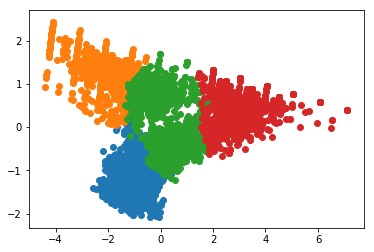

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

### 2.5：クラスタリング結果をもとに退会顧客の傾向を把握する

In [ ]:
# グループごとの退会ユーザー、継続ユーザーを集計してみる
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,822
1,0,1,19
2,1,0,1230
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [ ]:
# "cluster","routine_flg"でGROUPBYしてみる
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,789
2,1,0,2
3,1,1,1246
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


定期利用している継続ユーザーは、グループ0,1に多く存在していることが把握できます。

直感的にもなんとなく見えていた傾向が、より具体的に確認することができました

### 2.6：翌月の利用回数予測を行うためのデータ準備する
2018年11月の利用回数を予測してみようと思います。予測なので、当然２０１８年１１月以降のデータは使うことができないので、２０１８年５月〜１０月の6ヶ月のデータを使って、教師あり学習で予測モデルを作っていきます。

In [ ]:
# user_logから、年月と顧客ごとの集計を行います
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [ ]:
# 対象となるデータの整形
year_months = list(uselog_months["年月"].unique()) # 対象となる年月データをリストに格納
predict_data = pd.DataFrame()
for i in range(6, len(year_months)): # 2018年5月から2018年10月までのデータを作成します
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]] # ユーザーごと過去6ヶ月分のデータを情報として付与する
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7): # count_0から当月、そこから過去6ヶ月分の利用回数を1ヶ月ごとカウントする
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left") #　データを格納
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [ ]:
predict_data = predict_data.dropna() # 対象ユーザーを、6ヶ月以上契約しているユーザーに絞る
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### 2.7：特徴となる変数を付与する

In [ ]:
# 会員期間を特徴となる変数として加える
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [ ]:
# 会員期間の追加
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### 2.8：来月の利用回数予測モデルを作成する
古くから契約しているユーザーは契約時初期からのデータが存在していなかったり、現在利用回数が安定している（特徴が見えづらい）可能性があるため、2018年４月以降に、新規に入った顧客に絞ってモデル作成しようと思います。

In [ ]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")] # 絞り込み
from sklearn import linear_model # シンプルな回帰モデル、線形回帰(予測)モデルを呼び出す
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y) # この場合、デフォルトでは学習用データ７５％、テスト用データ２５％に分割される(train_size, test_sizeで指定可能)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6057457835561497
0.6125748997328535


### 2.9：モデルに寄与している変数を確認する

In [ ]:
# 変数のモデル寄与率
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.319063
1,count_1,0.203130
2,count_2,0.187548
3,count_3,0.175472
4,count_4,0.070523
5,count_5,0.067075
6,period,0.032488


### 2.10：来月の利用回数を予測する

In [ ]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [ ]:
model.predict(x_pred)

array([3.72933601, 1.94088045])

In [ ]:
uselog_months.to_csv("use_log_months.csv",index=False)

### 予測はできたけれど、
そもそも重要なことは、ユーザーを定着させて増やしていきたいはずなので、退会ユーザーを減らすことを考えないといけないはず。退会ユーザーがなぜ退会するのかを、分析してみる

### 3.1：データを読み込んで利用データを整形する

In [ ]:
import pandas as pd
customer = pd.read_csv('DATA/customer_join.csv')
uselog_months = pd.read_csv('DATA/use_log_months.csv')

In [ ]:
# 退会してしまうユーザーの予測を行うためのデータを作る
# 当月と過去1ヶ月分の利用回数を作ってみる 2018年4月、５月
year_months = list(uselog_months["年月"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-1]]
    del tmp_before["年月"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog.head()

,年月,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


### 3.2：退会前月の退会顧客データを作成する

In [ ]:
from dateutil.relativedelta import relativedelta
exit_customer = customer.loc[customer["is_deleted"]==1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)
exit_customer["年月"] = exit_customer["exit_date"].dt.strftime("%Y%m")
uselog["年月"] = uselog["年月"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "年月"], how="left")
print(len(uselog))
exit_uselog.head()

33851


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,通常,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


### 3.3：継続顧客のデータを作成する

In [ ]:
conti_customer = customer.loc[customer["is_deleted"]==0]
conti_uselog = pd.merge(uselog, conti_customer, on=["customer_id"], how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"])
print(len(conti_uselog))

33851
27422


In [ ]:
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True)
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")
print(len(conti_uselog))
conti_uselog.head()

2842


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201902,GD257285,5,5.0,XXXX,C01,M,2017-07-01,NaN,CA2,...,オールタイム,10500.0,入会費半額,5.583333,6.0,7.0,4.0,1.0,2019-04-30,21.0
1,201806,PL558375,7,5.0,XXXX,C02,F,2017-11-01,NaN,CA1,...,デイタイム,7500.0,通常,6.250000,6.0,9.0,5.0,1.0,2019-04-30,17.0
2,201903,TS885968,4,4.0,XXXXX,C01,F,2017-06-01,NaN,CA1,...,オールタイム,10500.0,通常,6.083333,6.0,10.0,3.0,1.0,2019-04-30,22.0
3,201806,HD476406,7,6.0,XXXXX,C01,F,2016-06-01,NaN,CA1,...,オールタイム,10500.0,通常,5.083333,5.5,8.0,2.0,1.0,2019-04-30,34.0
4,201806,HI708658,7,4.0,XXX,C01,F,2015-08-01,NaN,CA1,...,オールタイム,10500.0,通常,4.166667,4.0,7.0,1.0,1.0,2019-04-30,44.0


In [ ]:
predict_data = pd.concat([conti_uselog, exit_uselog],ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


,calc_date,campaign_id,campaign_name,class,class_name,count_0,count_1,customer_id,end_date,exit_date,...,max,mean,median,membership_period,min,name,price,routine_flg,start_date,年月
0,2019-04-30,CA2,入会費半額,C01,オールタイム,5,5.0,GD257285,NaN,NaN,...,7.0,5.583333,6.0,21.0,4.0,XXXX,10500.0,1.0,2017-07-01,201902
1,2019-04-30,CA1,通常,C02,デイタイム,7,5.0,PL558375,NaN,NaN,...,9.0,6.250000,6.0,17.0,5.0,XXXX,7500.0,1.0,2017-11-01,201806
2,2019-04-30,CA1,通常,C01,オールタイム,4,4.0,TS885968,NaN,NaN,...,10.0,6.083333,6.0,22.0,3.0,XXXXX,10500.0,1.0,2017-06-01,201903
3,2019-04-30,CA1,通常,C01,オールタイム,7,6.0,HD476406,NaN,NaN,...,8.0,5.083333,5.5,34.0,2.0,XXXXX,10500.0,1.0,2016-06-01,201806
4,2019-04-30,CA1,通常,C01,オールタイム,7,4.0,HI708658,NaN,NaN,...,7.0,4.166667,4.0,44.0,1.0,XXX,10500.0,1.0,2015-08-01,201806


### 3.4：予測する月の在籍期間を作成する

In [ ]:
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years*12 + delta.months)
predict_data.head()

,calc_date,campaign_id,campaign_name,class,class_name,count_0,count_1,customer_id,end_date,exit_date,...,median,membership_period,min,name,price,routine_flg,start_date,年月,period,now_date
0,2019-04-30,CA2,入会費半額,C01,オールタイム,5,5.0,GD257285,NaN,NaN,...,6.0,21.0,4.0,XXXX,10500.0,1.0,2017-07-01,201902,19,2019-02-01
1,2019-04-30,CA1,通常,C02,デイタイム,7,5.0,PL558375,NaN,NaN,...,6.0,17.0,5.0,XXXX,7500.0,1.0,2017-11-01,201806,7,2018-06-01
2,2019-04-30,CA1,通常,C01,オールタイム,4,4.0,TS885968,NaN,NaN,...,6.0,22.0,3.0,XXXXX,10500.0,1.0,2017-06-01,201903,21,2019-03-01
3,2019-04-30,CA1,通常,C01,オールタイム,7,6.0,HD476406,NaN,NaN,...,5.5,34.0,2.0,XXXXX,10500.0,1.0,2016-06-01,201806,24,2018-06-01
4,2019-04-30,CA1,通常,C01,オールタイム,7,4.0,HI708658,NaN,NaN,...,4.0,44.0,1.0,XXX,10500.0,1.0,2015-08-01,201806,34,2018-06-01


### 3.5：欠損値を除去する

In [ ]:
predict_data.isna().sum()

calc_date               0
campaign_id             0
campaign_name           0
class                   0
class_name              0
count_0                 0
count_1               259
customer_id             0
end_date             2842
exit_date            2842
gender                  0
is_deleted              0
max                     0
mean                    0
median                  0
membership_period       0
min                     0
name                    0
price                   0
routine_flg             0
start_date              0
年月                      0
period                  0
now_date                0
dtype: int64

In [ ]:
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

calc_date               0
campaign_id             0
campaign_name           0
class                   0
class_name              0
count_0                 0
count_1                 0
customer_id             0
end_date             2635
exit_date            2635
gender                  0
is_deleted              0
max                     0
mean                    0
median                  0
membership_period       0
min                     0
name                    0
price                   0
routine_flg             0
start_date              0
年月                      0
period                  0
now_date                0
dtype: int64

### 3.6：文字列型の変数を処理できるように整形する

In [ ]:
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,入会費半額,オールタイム,M,5.0,1.0,19,0.0
1,通常,デイタイム,F,5.0,1.0,7,0.0
2,通常,オールタイム,F,4.0,1.0,21,0.0
3,通常,オールタイム,F,6.0,1.0,24,0.0
4,通常,オールタイム,F,4.0,1.0,34,0.0


In [ ]:
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,gender_F,gender_M
0,5.0,1.0,19,0.0,1,0,0,1,0,0,0,1
1,5.0,1.0,7,0.0,0,0,1,0,1,0,1,0
2,4.0,1.0,21,0.0,0,0,1,1,0,0,1,0
3,6.0,1.0,24,0.0,0,0,1,1,0,0,1,0
4,4.0,1.0,34,0.0,0,0,1,1,0,0,1,0


In [ ]:
del predict_data["campaign_name_通常"]
del predict_data["class_name_ナイト"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,5.0,1.0,19,0.0,1,0,1,0,0
1,5.0,1.0,7,0.0,0,0,0,1,1
2,4.0,1.0,21,0.0,0,0,1,0,1
3,6.0,1.0,24,0.0,0,0,1,0,1
4,4.0,1.0,34,0.0,0,0,1,0,1


### 3.7：決定木を用いて退会予測モデルを作成する

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

exit = predict_data.loc[predict_data["is_deleted"]==1]
conti = predict_data.loc[predict_data["is_deleted"]==0].sample(len(exit))

X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.

In [ ]:
results_test = pd.DataFrame({"y_test":y_test ,"y_pred":y_test_pred })
results_test.head()

,y_test,y_pred
1308,0.0,1.0
111,1.0,1.0
1645,0.0,0.0
1746,0.0,0.0
1948,0.0,0.0


### 3.8：予測モデルの評価を行ない、モデルのチューニングする

In [ ]:
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count = len(results_test)
score_test = correct / data_count
print(score_test)

0.8802281368821293


In [ ]:
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8802281368821293
0.9759188846641318


In [ ]:
X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9182509505703422
0.9214195183776933


### 3.9：モデルに寄与している変数を確認する

In [ ]:
importance = pd.DataFrame({"feature_names":X.columns, "coefficient":model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.334445
1,routine_flg,0.138804
2,period,0.524600
3,campaign_name_入会費半額,0.000000
4,campaign_name_入会費無料,0.000000
5,class_name_オールタイム,0.000000
6,class_name_デイタイム,0.002151
7,gender_F,0.000000


### 3.10：顧客の退会を予測する

In [ ]:
count_1 = 3
routine_flg = 1
period = 10
campaign_name = "入会費無料"
class_name = "オールタイム"
gender = "M"

In [ ]:
if campaign_name == "入会費半額":
    campaign_name_list = [1, 0]
elif campaign_name == "入会費無料":
    campaign_name_list = [0, 1]
elif campaign_name == "通常":
    campaign_name_list = [0, 0]
if class_name == "オールタイム":
    class_name_list = [1, 0]
elif class_name == "デイタイム":
    class_name_list = [0, 1]
elif class_name == "ナイト":
    class_name_list = [0, 0]
if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]
input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

In [ ]:
print(model.predict([input_data]))
print(model.predict_proba([input_data]))

[1.]
[[0.00278552 0.99721448]]
